# Assignment 2 - Q4 (Programming Exercise)
#### Bishal Chaulahain, Nishan Nepal, Shristi Heuju, Sushant Gautam

In [11]:
import numpy as np  #used for square-root, power and linear space divison function
import matplotlib.pyplot as plt # for beautiful plots 
import scipy.integrate as integrate # uses a technique from the Fortran library QUADPACK
from numpy import genfromtxt #to parse Anil K Jain table from CSV

The general form of its probability density function is:
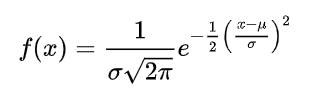

In [12]:
def normal_dist(x, mean=0.0, vari=1.0):
    """
    A normal distribution function
    """
    return (1.0/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))

In [13]:
def MSEintegrand(x, yVal):
    """
    comment
    """
    return  ((x- yVal)**2) * normal_dist(x)

In [14]:
def yUpdateNumerator(x):
    return  x * normal_dist(x)

def yUpdateDenominator  (x):
    return  normal_dist(x)

def yUpdate(lower, upper):
    """
    comment
    """
    return integrate.quad( yUpdateNumerator,lower, upper,)[0]\
                                     /integrate.quad( yUpdateDenominator,lower, upper,)[0]

In [15]:
def UniformQuantizer(x):
    """
    comment
    """
    return [{"from": x[i], "to": x[i+1], "value":( x[i]+ x[i+1])/2, } for i in range(len(x)-1)]

In [16]:
def LyoidMax(x, yquant):
    """
    comment
    """
    y =  [e['value'] for e in yquant]
    threshold = 0.00001
    print(".", end ="") #progress for each 
    b, sigma=  [ x[e] for e in range(len(x))] , 10000

    c=0
    while True and c < 300:
        c+=1
        for i in  range(1, len(y)):
            b[i]= (y[i-1]+ y[i])/2 
        sigma = sum([integrate.quad(MSEintegrand, b[i], b[i+1], y[i])[0] for i in range(len(x)-1)])
        if sigma < threshold: print('break'); break
        y=[yUpdate(b[i], b[i+1]) for i in range(len(x)-1)]
    toReturn=[]
    for i, e in enumerate(y):
        toReturn.append({"value":e , "from":b[i] , "to":b[i+1]})
    return toReturn, b, [normal_dist(e) for e in b]

## (a) Assume the variance to be one and plot the PDF of a zero-mean Gaussian random variable.

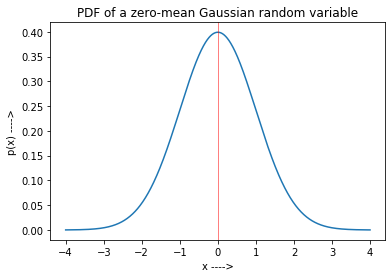

In [17]:
def PlotGaussian():
    """
    comment
    """
    plt.plot(np.linspace(-4, 4, 1000 ),  [normal_dist(i) for i in np.linspace(-4, 4, 1000 )],  label='gaussian curve')
    plt.xlabel('x ---->') ; plt.ylabel('p(x) ---->')
    plt.title('PDF of a zero-mean Gaussian random variable')
    plt.axvline(x=0, color="red", linewidth=0.5) #mean
PlotGaussian()

## (b-1) Apply a Uniform Quantizer to the PDF in (a). Make a new figure showing the decision boundaries and reconstruction levels superimposed on the PDF of (a).

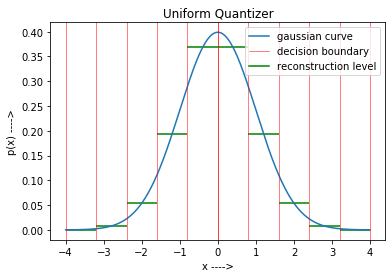

In [18]:
def Quantizer(LyoidMaxAlgorithm=False, label=None,):
    """
    comment
    """
    Data =[]
    for m in range(2, 32, 1):
        M=m #Number of quantization levels
        Xmin, Xmax = -4, 4
        x= np.linspace(Xmin,Xmax, M+1 ) #evenly spaced M samples over a specified interval.
        y = [normal_dist(i) for i in np.linspace(Xmin,Xmax, M+1 )] #  #quant levels
        yqant = UniformQuantizer(x) #quantized data
        if LyoidMaxAlgorithm: yqant,x, y = LyoidMax(x, yqant)
        QuantError = sum([integrate.quad(MSEintegrand, v['from'], v['to'],v['value'] )[0] for v in yqant])
        Data.append({"error" :QuantError, "M": M, "LyoidMaxAlgorithm": yqant})

        if M==10:
            PlotGaussian()
            for i in x: plt.axvline(x=i, color="red", linewidth=0.5,) # horizontal lines representing levels
            plt.plot(0, 0,color="red",linewidth=0.5, label='decision boundary') #just for legend
            
#             plt.plot(x, y) # reconstructed graph
            
            for i in yqant: plt.hlines(y = normal_dist(i['value']), xmin = i['from'], xmax = i['to'], color="green")   #quant level
            plt.plot(0, 0,color="green", label='reconstruction level') #just for legend
            
            plt.xlabel('x ---->') ; plt.ylabel('p(x) ---->')
            plt.title(label)
            plt.legend() ; plt.show()
    return Data

uniQuantizerData = Quantizer(LyoidMaxAlgorithm=False, label="Uniform Quantizer")

## (b-1) Vary the number of decision boundaries and plot the quantization error versus the number of quantization levels

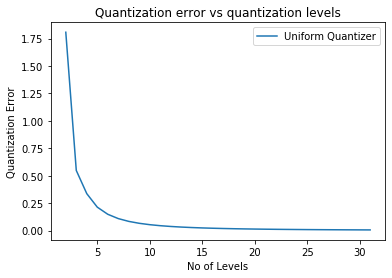

In [19]:
def PlotData(data, label):
    """
    comment
    """
    plt.plot([e['M'] for e in data], [e['error'] for e in data],label=label )
    plt.xlabel('No of Levels')
    plt.ylabel('Quantization Error')
    plt.title('Quantization error vs quantization levels')
    plt.legend() ; plt.show()
PlotData(uniQuantizerData, label="Uniform Quantizer")

## (c-1) Implement  the Llyod-Max  Algorithmto the  PDF  of  (a).  Make  a  new  figure  showing  the  decision  boundaries  and reconstruction levels superimposed on the PDF of (a).

.........

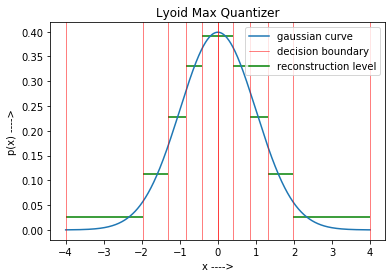

.....................

In [20]:
nonUniQData = Quantizer(LyoidMaxAlgorithm=True, label="Lyoid Max Quantizer")

## (c-2) Vary the number of decision boundaries and plot the quantization error versus the number of quantization levels.

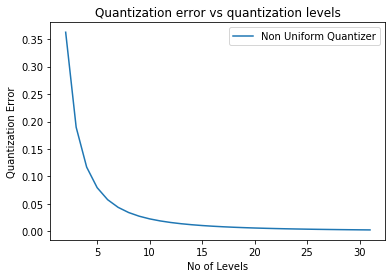

In [21]:
PlotData(nonUniQData, label="Non Uniform Quantizer")

## (d) For both (a) and (b) choose the same number of quantization levels and compare the performance between (a) and (b) in terms of quantization errors.

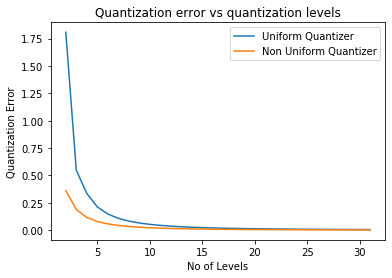

In [22]:
plt.plot([e['M'] for e in uniQuantizerData],[e['error'] for e in uniQuantizerData],label="Uniform Quantizer" )
plt.plot([e['M'] for e in nonUniQData],[e['error'] for e in nonUniQData],label="Non Uniform Quantizer" )
plt.xlabel('No of Levels')
plt.ylabel('Quantization Error')
plt.title('Quantization error vs quantization levels')
plt.legend() ; plt.show()

### (e) Compare your answer with the  values given on pages104 (Table 4.1) and 116 (Table 4.3) of "Fundamentalsof Digital Image Processing" by Anil K. Jain

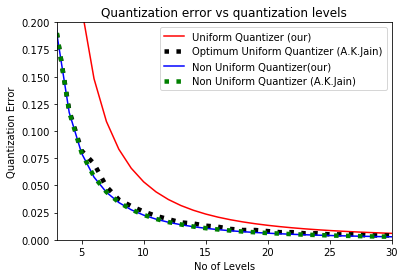

In [23]:
AKJData = genfromtxt('AnilJainTable4.1 and 4.3.csv', delimiter=',')
plt.plot([e['M'] for e in uniQuantizerData],[e['error'] for e in uniQuantizerData],color='red',label="Uniform Quantizer (our)" )
plt.plot([e[0] for e in AKJData],[e[2] for e in AKJData], \
         label="Optimum Uniform Quantizer (A.K.Jain)",linewidth=4.5, color='black', linestyle=':')

plt.plot([e['M'] for e in nonUniQData],[e['error'] for e in nonUniQData], color='blue',label="Non Uniform Quantizer(our)" )
plt.plot([e[0] for e in AKJData],[e[1] for e in AKJData], \
         label="Non Uniform Quantizer (A.K.Jain) ",linewidth=4.5, color='green', linestyle=':') 
plt.xlabel('No of Levels')
plt.ylabel('Quantization Error')
plt.title('Quantization error vs quantization levels')
plt.ylim(0.0, 0.2); plt.xlim(3, 30)
plt.legend() ; plt.show()

## Conclusion

The output seems to be same for both experiments in case of non uniform quantizer.
However,we had taken mid point ( of course non optimal) value between the boundary for Uniform quantizer. On the other hand, Jain had used some optimal value. His result for both uniform and non uniform are comparable. In our case, uniform quantizer is worse than his optimzal uniform quantizer. . . . . .